In [2]:
def update_github_files():
    !git add ReproductiveSkewSimulations.ipynb
    !git add ReproductiveSkewSimulations_v2.ipynb
    !git add fertSignals_0d_GA_v2.ipynb
    !git add pymate.py
    !git add pymate_tests.ipynb
    !git add pymate_gui.py
    !git commit -m "bug fixes"
    !git push -u origin master
    
update_github_files()

On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
	modified:   pymate_tests.ipynb

Untracked files:
	.ipynb_checkpoints/
	__pycache__/
	combined_swellings_ABM.ipynb

no changes added to commit
ssh: connect to host github.com port 22: Connection refused
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [77]:
list_of_q = np.random.uniform(1,2,10)
list_of_c = np.array([1.0] * 10)

In [78]:
list_of_q

array([1.06043408, 1.96759613, 1.28349148, 1.03570773, 1.08579869,
       1.80656733, 1.09288559, 1.86159522, 1.79111022, 1.73137185])

In [85]:
list_of_c[0] = 4.00

In [86]:
list_of_q**list_of_c

array([1.26454624, 1.96759613, 1.28349148, 1.03570773, 1.08579869,
       1.80656733, 1.09288559, 1.86159522, 1.79111022, 1.73137185])

In [62]:
0.03140595 ** 1.85

0.0016575707697893155

In [92]:
list_of_c

array([4., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(array([312., 229., 172., 112.,  78.,  52.,  30.,  11.,   3.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

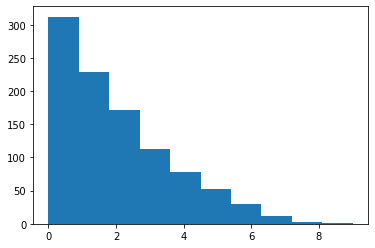

In [128]:
l = []
for i in range(1000):
    model.groups[0].males[0].competitive_effort = 4.5
    model.groups[0].set_ranks()
    l.append(model.groups[0].males[0].rank)
plt.hist(l)

In [130]:
[f"quality: {round(m.quality,3)}, competitive_effort: {m.competitive_effort}, entries: {round(m.quality**m.competitive_effort,3)}, rank: {m.rank}" for m in model.groups[0].males]

['quality: 1.967, competitive_effort: 1.2920290496776918, entries: 2.396, rank: 0',
 'quality: 1.013, competitive_effort: 1.2684556437734666, entries: 1.016, rank: 1',
 'quality: 1.503, competitive_effort: 1.4051318125124368, entries: 1.773, rank: 2',
 'quality: 1.215, competitive_effort: 1.2083300328358826, entries: 1.265, rank: 3',
 'quality: 1.042, competitive_effort: 1.2684556437734666, entries: 1.053, rank: 4',
 'quality: 1.841, competitive_effort: 1.2684556437734666, entries: 2.169, rank: 5',
 'quality: 1.686, competitive_effort: 1.2684556437734666, entries: 1.939, rank: 6',
 'quality: 1.858, competitive_effort: 1.2684556437734666, entries: 2.194, rank: 7',
 'quality: 1.161, competitive_effort: 1.4051318125124368, entries: 1.233, rank: 8',
 'quality: 1.102, competitive_effort: 1.4051318125124368, entries: 1.146, rank: 9']

59
60
62
64
67
96
122
140
142
169
172
174
194
201
218
235
242
244
252
259
270
272
283
297
300
305
306
311
318
328
337
345
356
365
398
400
401
404
422
467
481
503
512
519
525
530
535
572
593
600
610
612
632
639
642
666
668
669
696
699
701
711
718
724
726
730
742
786
789
800
801
808
824
826
827
842
847
861
871
900
902
908
914
923
934
947
949
965
967
973
994
1017
1054
1056
1087
1101
1104
1107
1133
1138
1142
1143
1144
1146
1163
1164
1178
1183
1193
1227
1237
1238
1244
1250
1254
1282
1287
1289
1291
1295
1321
1332
1340
1342
1345
1349
1350
1352
1373
1382
1388
1404
1408
1435
1443
1465
1480
1488
1499
1523
1548
1566
1578
1584
1588
1602
1603
1606
1607
1609
1614
1618
1638
1641
1647
1655
1663
1676
1696
1699
1700
1703
1750
1756
1761
1763
1770
1771
1782
1788
1811
1816
1819
1841
1842
1847
1849
1851
1856
1875
1877
1880
1882
1886
1892
1897
1906
1907
1910
1929
1946
1948
1968
1969
1976
1996
2002
2006
2026
2027
2045
2049
2068
2071
2088
2099
2100
2112
2124
2153
2168
2170
2186
2189
2215
2226
2241
2242
2255
22

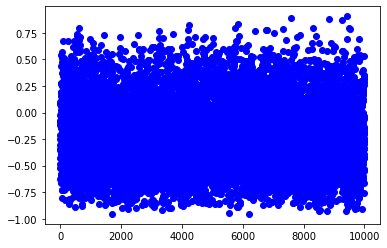

In [137]:
model = pymate.population()
pymate.number_generations = 10000
model.evolve()
plt.plot(model.groups[0].list_of_rank_quality_corrlations, 'bo')

(array([ 203.,  887., 1675., 1941., 1858., 1385.,  741.,  383.,  107.,
          22.]),
 array([-0.95467739, -0.7685463 , -0.58241521, -0.39628412, -0.21015303,
        -0.02402193,  0.16210916,  0.34824025,  0.53437134,  0.72050243,
         0.90663353]),
 <BarContainer object of 10 artists>)

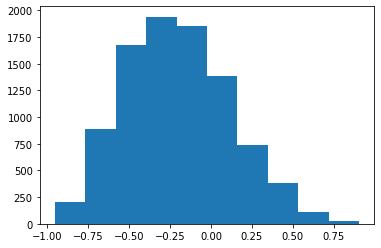

In [140]:
plt.hist(model.groups[0].list_of_rank_quality_corrlations[800:])

ReproductiveSkewSimulations.ipynb    fertSignals_0d_GA_v2.ipynb
ReproductiveSkewSimulations_v2.ipynb pymate.py
__pycache__                          pymate_gui.py
combined_swellings_ABM.ipynb         pymate_tests.ipynb
